Estimate a DWI signal using the eddymotion Gaussian Process (GP) regressor estimator.

Download the "Sherbrooke 3-shell" dataset using DIPY and select the b=1000 s/mm^2 shell data.

In [1]:
import dipy.data as dpd
import nibabel as nib
import numpy as np
from dipy.core.gradients import get_bval_indices
from dipy.io import read_bvals_bvecs
from dipy.segment.mask import median_otsu
from scipy.ndimage import binary_dilation
from skimage.morphology import ball

name = "sherbrooke_3shell"

dwi_fname, bval_fname, bvec_fname = dpd.get_fnames(name=name)
dwi_data = nib.load(dwi_fname).get_fdata()
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)

_, brain_mask = median_otsu(dwi_data, vol_idx=[0])
brain_mask = binary_dilation(brain_mask, ball(8))

bval = 1000
indices = get_bval_indices(bvals, bval, tol=20)

bvecs_shell = bvecs[indices]
shell_data = dwi_data[..., indices]

Let's leave one direction out:

In [3]:
dwi_vol_idx = len(indices) // 2

# Prepare a train/test mask (False for all directions except the left-out where it's true)
train_test_mask = np.zeros(bvecs_shell.shape[0], dtype=bool)
train_test_mask[dwi_vol_idx] = True

# Generate train/test bvecs
X_train = bvecs_shell[~train_test_mask, :]
X_test = bvecs_shell[train_test_mask, :]

# Select voxels within brain mask
y = shell_data[brain_mask]

# Generate train/test data
y_train = y[:, ~train_test_mask]
y_test = y[:, train_test_mask]

Visualize a slice of the data for a given DWI volume.

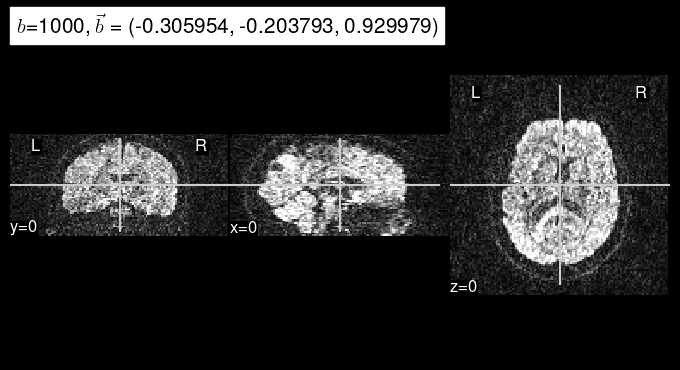

In [4]:
from nireports.reportlets.modality.dwi import plot_dwi

affine = nib.load(dwi_fname).affine
plot_dwi(
    shell_data[..., dwi_vol_idx],
    affine,
    gradient=np.concatenate((np.squeeze(X_test), [1000])),
    output_file="sherbrooke_3shell_b1k_data.svg",
)

Define the EddyMotionGPR instance.

In [5]:
from eddymotion.model.gpr import EddyMotionGPR, SphericalKriging

beta_a = 1.38
beta_l = 1 / 2.1
kernel = SphericalKriging(beta_a=beta_a, beta_l=beta_l)

alpha = 0.1
disp = True
optimizer = None
gpr = EddyMotionGPR(kernel=kernel, alpha=alpha, disp=disp, optimizer=optimizer)

1. Fit and do not optimize the parameters in the fitting.
2. Predict on a single diffusion-encoding gradient direction.

In [6]:
gpr = gpr.fit(X_train, y_train.T)

y_sim = np.squeeze(gpr.predict(X_test))

dwi_sim = np.zeros_like(shell_data[..., 0])
dwi_sim[brain_mask] = y_sim

And now, visualize:

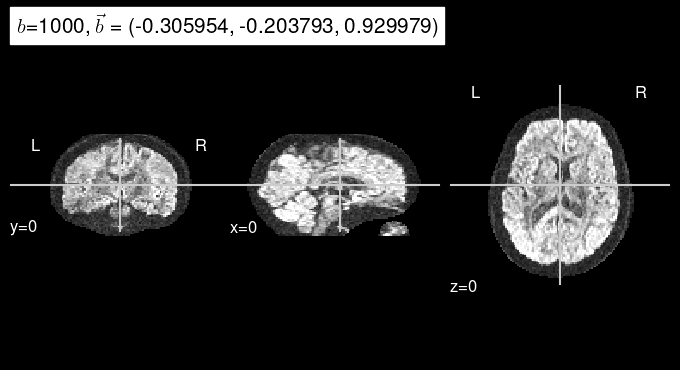

In [7]:
plot_dwi(
    dwi_sim,
    affine,
    gradient=np.concatenate((np.squeeze(X_test), [1000])),
    output_file="sherbrooke_3shell_b1k_gp_noopt_pred.svg",
)

In [8]:
rmse = np.sqrt((y_test.squeeze() - y_sim) ** 2)

print(f"RMSE: {rmse.mean()}")
threshold = 10
n_error_thr = len(rmse[rmse > threshold])
ratio = n_error_thr / len(rmse) * 100
print(f"Number of RMSE values above {threshold}: {n_error_thr} ({ratio:.2f}%)")

RMSE: 20.092110897117276
Number of RMSE values above 10: 199698 (67.21%)


Let's now allow our GP to fit a and λ on the full dataset

In [9]:
gpr = EddyMotionGPR(kernel=kernel, alpha=alpha, disp=disp, optimizer="fmin_l_bfgs_b", ftol=0.1)
gpr = gpr.fit(bvecs_shell, y.T)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16597D+07    |proj g|=  7.64969D+00

At iterate    1    f=  3.02802D+07    |proj g|=  8.01781D+00

At iterate    2    f=  2.96130D+07    |proj g|=  7.92633D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      3     0     0   7.926D+00   2.961D+07
  F =   29612979.200755097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Now we check the fitted parameters:

In [10]:
gpr.kernel_, gpr.kernel

(SphericalKriging (a=0.8841585520664049, λ=2.769244783648302),
 SphericalKriging (a=1.38, λ=0.47619047619047616))

Let's create a new GPR with the new parameters (we should check this, I don't understand why the fitted parameters are not set back)

In [11]:
gpr = EddyMotionGPR(kernel=gpr.kernel_, alpha=alpha, disp=disp, optimizer=None)
gpr = gpr.fit(X_train, y_train.T)
y_sim2 = np.squeeze(gpr.predict(X_test))

dwi_sim2 = np.zeros_like(shell_data[..., 0])
dwi_sim2[brain_mask] = y_sim2

Let's check RMSE

In [12]:
rmse = np.sqrt((y_test.squeeze() - y_sim2) ** 2)

print(f"RMSE: {rmse.mean()}")
threshold = 10
n_error_thr = len(rmse[rmse > threshold])
ratio = n_error_thr / len(rmse) * 100
print(f"Number of RMSE values above {threshold}: {n_error_thr} ({ratio:.2f}%)")

RMSE: 21.310449692859184
Number of RMSE values above 10: 204399 (68.79%)


And now we visualize the new simulated orientation

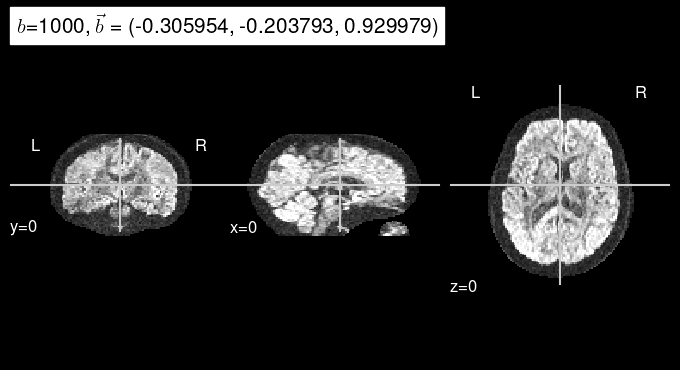

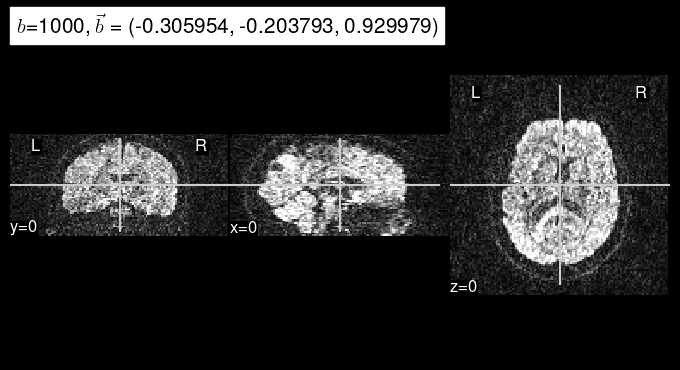

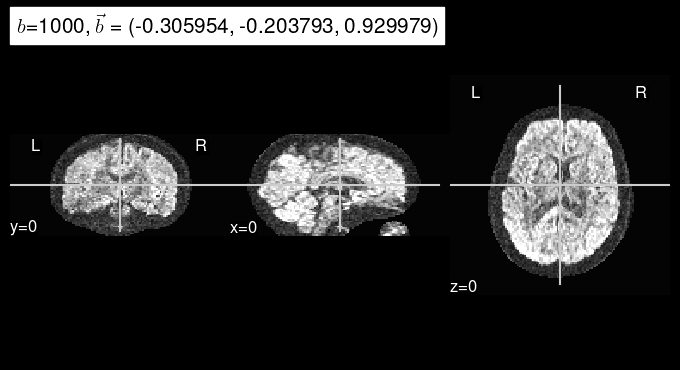

In [13]:
plot_dwi(dwi_sim, affine, gradient=np.concatenate((np.squeeze(X_test), [1000])))
plot_dwi(
    shell_data[..., dwi_vol_idx], affine, gradient=np.concatenate((np.squeeze(X_test), [1000]))
)
plot_dwi(
    dwi_sim2,
    affine,
    gradient=np.concatenate((np.squeeze(X_test), [1000])),
    output_file="sherbrooke_3shell_b1k_gp_opt_pred.svg",
)